### Pairwise Relevance Task Data Generation

dl4MARCO paper describes that they used BM25 ranking on train data queries to get the top 1k for each query. These 1k are then used as training data for the binary classification task for that query - all the relevant retrieved are maked as 1 and irrevant are marked as 0.

In our case we have accepted answers for each question (500k). So we can use accepted answers as proxies for relevancy.

We can search each question in the answer index to get top 10 answers.
- if the candidate is an accepted answer we mark it as 1 (positive-candidate)
- if the candidate is not accepted we mark it as 0 (negative-candidate)
    - we also make sure the negative-candidate is not in the list of other answers for that question

TODO : 
Add answers with positive scores as well

| id     | ques_id   | ans_id   | question                                                                   | answer                                                                                                                 | is_relevant |
|--------|--------|--------|-----------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------|--------------|
| 133273 | 213221 | 213222 | How is the life of a math student? Could you describe your own experiences? | Which level of prepration is enough for the exam jlpt5? 0                                                                 |              |
| 402555 | 536040 | 536041 | How do I control my horny emotions?                                         | How do you control your horniness?                                                                                        | 1            |
| 360472 | 364011 | 490273 | What causes stool color to change to yellow?                                | What can cause stool to come out as little balls?                                                                         | 0            |
| 150662 | 155721 | 7256   | What can one do after MBBS?                                                 | What do i do after my MBBS ?1                                                                                             |              |
| 183004 | 279958 | 279959 | Where can I find a power outlet for my laptop at Melbourne Airport?         | Would a second airport in Sydney, Australia be needed if a high-speed rail link was created between Melbourne and Sydney? | 0            |

In [3]:
header = ["id","qid1","qid2","question1","question2","is_duplicate"]

In [4]:
ans_path = '/data/szr207/dataset/ArqMath/jsons/answers/all.ans.jsonl'
ques_path = '/data/szr207/dataset/ArqMath/jsons/questions/all.ques.jsonl'

In [5]:
import glob
from tqdm import tqdm
import os
import jsonlines
import re
from elasticsearch import Elasticsearch
from collections import defaultdict
import pandas as pd


In [6]:
dict_ans = {}

with jsonlines.open(os.path.join(ans_path)) as reader:
        for obj in tqdm(reader):
            dict_ans[obj['post_id']] = obj

1435643it [00:34, 41917.76it/s]


In [7]:

dict_ques = {}

with jsonlines.open(os.path.join(ques_path)) as reader:
        for obj in tqdm(reader):
            dict_ques[obj['post_id']] = obj

1029449it [00:35, 28793.69it/s]


In [94]:
count = 0

list_ques = []
list_ans = []
list_ques_idx = []
list_ans_idx = []

# N = 

for qid in tqdm(list(dict_ques.keys())):
    if dict_ques[qid]['accepted_answer_id'] in dict_ans:
        ans_body = re.sub('<[^<]+?>', '',  dict_ans[dict_ques[qid]['accepted_answer_id']]['body'])
        ques_body = re.sub('<[^<]+?>', '',  dict_ques[qid]['body'])
        ques_title = re.sub('<[^<]+?>', '',  dict_ques[qid]['title'])
        
        list_ques.append(ques_title + '. ' +ques_body)
        list_ans.append(ans_body)
        
        list_ques_idx.append(qid)
        list_ans_idx.append(dict_ques[qid]['accepted_answer_id'])

100%|██████████| 1029449/1029449 [00:25<00:00, 40872.70it/s]


In [95]:
list_ans_idx[:2], list_ques_idx[:2]

([16021, 16024], [16020, 16022])

In [96]:
def remove_stop(query):
    with open('englishST.txt') as f:
        all_stopwords = f.readlines()
    # you may also want to remove whitespace characters like `\n` at the end of each line
    all_stopwords = [x.strip() for x in all_stopwords] 
    text_tokens = query.split(' ')
    query = [word for word in text_tokens if not word in all_stopwords]
    query = ' '.join(query)
    return query

In [97]:
es = Elasticsearch(['http://localhost:9200/'], verify_certs=True)

In [65]:
# negative_ans = defaultdict(list)
# for ans, query, ans_idx, ques_idx in tqdm(zip(list_ans, list_ques, list_ans_idx, list_ques_idx)):
#     list_q_a = []
#     query = remove_stop(query)
#     body = {
#         "size": 11,
#         "query": {
#             "match": {
#                 "body": query
#             }
#         }
#     }
#     res = es.search(index="answer_bulk_index", body=body)
#     for result in res['hits']['hits']:
#         list_q_a.append(result['_source']['post_id'])
#     if ans_idx in list_q_a: list_q_a.remove(ans_idx)
#     negative_ans[query].append(list_q_a[:10])
# #     print(len(list_q_a[:10]))

In [98]:
request = []
for ans, query, ans_idx, ques_idx in tqdm(zip(list_ans, list_ques, list_ans_idx, list_ques_idx)):
    query = remove_stop(query)
    req_head = {'index': 'answer_bulk_index'}
    req_body = {
            "size": 11,
            "query": {
                "match": {
                    "body": query
                }

            }
        }
    request.extend([req_head, req_body])

546145it [07:35, 1198.79it/s]


In [99]:
def divide_chunks(list_log, N): 
    # looping till length l 
    for i in range(0, len(list_log), N):  
        yield list_log[i:i + N] 

req_batch = list(divide_chunks(request, N=100))

In [100]:
list_resp = []
for req in tqdm(req_batch):
    resp = es.msearch(body = req)
    list_resp.append(resp)

  1%|▏         | 146/10923 [04:54<6:01:44,  2.01s/it] 


KeyboardInterrupt: 

In [ ]:
len(list_resp)

In [ ]:
list_es = []
for chunk in tqdm(range(len(list_resp))):
    for chunk_res in list_resp[chunk]['responses']:
        list_res = []
        if 'hits' in chunk_res:
            for idx in chunk_res['hits']['hits']:
                list_res.append(idx['_source']['post_id'])
        list_es.append(list_res)

In [ ]:
len(list_es)

In [ ]:
dict_ques_es = {}

for res,acc_ans_idx,ques in tqdm(zip(list_es,list_ans_idx, list_ques_idx)):
    if acc_ans_idx in res: res.remove(acc_ans_idx)
    dict_ques_es[ques] = {
        "bm25" : res[:10],
        "acc_ans_id" : acc_ans_idx
    }    

In [ ]:
def reduce_str(body, N):
    if len(body.split()) > N:
        return ' '.join(body.split()[:N])
    else:
        return body
    
reduce_str("I love my chapi",2 )

In [ ]:
count = 1

idx = []

f_ques_idx = []
f_ans_idx = []

f_ques = []
f_ans = []

labels = []

len_token = 100

for ques_idx in tqdm(dict_ques_es):
    for ans_idx in dict_ques_es[ques_idx]['bm25']:
        
        idx.append(count)
        count+=1
        
        f_ques_idx.append(ques_idx)
        f_ans_idx.append(ans_idx)
        
        f_ques.append(reduce_str(re.sub('<[^<]+?>', '', dict_ques[ques_idx]['title']+'. '+dict_ques[ques_idx]['body']), len_token))
        f_ans.append(reduce_str(re.sub('<[^<]+?>', '',dict_ans[ans_idx]['body']),len_token))
        
        labels.append(0)
    
    idx.append(count)
    count+=1
    
    f_ques_idx.append(ques_idx)
    f_ans_idx.append(dict_ques_es[ques_idx]['acc_ans_id'])

    f_ques.append(reduce_str(re.sub('<[^<]+?>', '',dict_ques[ques_idx]['title']+'. '+dict_ques[ques_idx]['body']),len_token))
    f_ans.append(reduce_str(re.sub('<[^<]+?>', '',dict_ans[dict_ques_es[ques_idx]['acc_ans_id']]['body']),len_token))

    labels.append(1)
#     print(ques_idx,dict_ques_es[ques_idx]['acc_ans_id'], dict_ques[ques_idx], dict_ans[dict_ques_es[ques_idx]['acc_ans_id']],1)

In [ ]:
len(labels)

In [ ]:
header = ["id","qid1","qid2","question1","question2","is_duplicate"]

df = pd.DataFrame(columns=header)

df["id"] = idx
df["qid1"] = f_ques_idx
df["qid2"] = f_ans_idx

df['question1'] = f_ques
df['question2'] = f_ans

df['is_duplicate'] = labels

df.to_csv('armath_full.tsv', index=False, sep='\t')

In [ ]:
df.shape

In [93]:
!curl -X GET "localhost:9200/_cat/indices/twi*?v&s=index&pretty"

health status index uuid pri rep docs.count docs.deleted store.size pri.store.size


In [ ]:
!jupyter nbconvert --to script create_pairwise.ipynb

In [1]:
import pandas as pd

df_train = pd.read_csv('/data/szr207/projects/ArqMath/gold/train.tsv',sep='\t')


id   qid1     qid2                                          question1  \
0   1  16020    16025  Equivalent statements of the Axiom of Choice. ...   
1   2  16020   697264  Equivalent statements of the Axiom of Choice. ...   
2   3  16020  2645743  Equivalent statements of the Axiom of Choice. ...   
3   4  16020  2875568  Equivalent statements of the Axiom of Choice. ...   
4   5  16020  1650515  Equivalent statements of the Axiom of Choice. ...   

                                           question2  is_duplicate  
0  Assume the first form. Let I be any set and le...             0  
1  I know two equivalent definitions for an onto ...             0  
2  This is part of the all-important Corresponden...             0  
3  I am going to answer my own question. I had a ...             0  
4  More informally, elements of the free semigrou...             0

In [1]:
df_train.head(20) 

NameError: name 'df_train' is not defined

On 11k Test data :

|        | precision    | recall | f1-score | support |
|--------------|--------|----------|---------|-------|
| 0            | 0.93   | 0.99     | 0.96    | 9899  |
| 1            | 0.71   | 0.29     | 0.41    | 1102  |
| accuracy     | 0.92   |     |         |  11001     |
| macro avg    | 0.82   | 0.64     | 0.68    | 11001 |
| weighted avg | 0.90   | 0.92     | 0.90    | 11001 |


2% gain (92%) in accuracy as compared to random guess(90%).

71% Precision

29% Recall

Recall can be improved


|                    | Predicted Irrelevant | Predicted Relevant |
|--------------------|----------------------|--------------------|
| Actual  Irrelevant | 9772                 | 127                |
| Actual Relevant    | 786                  | 316                |

In [34]:
import seaborn as sns
import numpy as np

cf_matrix = np.array([[9772/9899,  127/9899],
       [ 786/1102,  316/1102]])

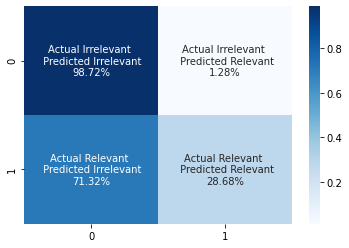

In [42]:
group_names =['Actual Irrelevant \n Predicted Irrelevant','Actual Irrelevant \n Predicted Relevant'\
              ,'Actual Relevant \n Predicted Irrelevant','Actual Relevant \n Predicted Relevant']
# group_counts = ["{0:0.0f}".format(value) for value in
#                 cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()]
labels = [f"{v1}\n{v3}" for v1, v3 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

categories = ['Irrelevant', 'Relevant']
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

### 4 Things
1. RoBERTa finetuning results
2. Training for relevance or just pretraining on our data ? as BERT RR is giving better results
3. Answer Tag prediction ? - for filtering 
4. Other ways to include formula